# Part 3. Data Serving. Linear Regression

### Load the parquet files

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Create a SparkSession with the best configuration
spark = (
    SparkSession.builder
    .appName("data_serving_LinearRegression")
    .config("spark.master", "yarn")
    .config("spark.driver.memory", "2g")
    .config("spark.yarn.am.memory", "2g")
    .config("spark.executor.memory", "4g")
    .config("spark.executor.cores", "4")
    .config("spark.executor.instances", "3")
    .config("spark.task.cpus", "1")
    .config("spark.dynamicAllocation.enabled", "false")
    .getOrCreate()
)

df = spark.read.parquet("hdfs:///project/cleaned_data_parquet")

df.show()


+----------+-----------+--------+--------+
|      date|temperature|feature1|feature2|
+----------+-----------+--------+--------+
|2000-01-01|         -6|    0.02|     1.0|
|2000-01-02|         -1|    0.03|     1.0|
|2000-01-03|          2|    0.05|     1.0|
|2000-01-04|          2|    0.07|     1.0|
|2000-01-05|         -1|    0.09|     1.0|
|2000-01-06|          5|     0.1|    0.99|
|2000-01-07|          4|    0.12|    0.99|
|2000-01-08|          6|    0.14|    0.99|
|2000-01-09|          1|    0.15|    0.99|
|2000-01-10|          0|    0.17|    0.99|
|2000-01-11|          3|    0.19|    0.98|
|2000-01-12|          2|    0.21|    0.98|
|2000-01-13|          1|    0.22|    0.98|
|2000-01-14|         -2|    0.24|    0.97|
|2000-01-15|         -3|    0.26|    0.97|
|2000-01-16|          0|    0.27|    0.96|
|2000-01-17|          8|    0.29|    0.96|
|2000-01-18|          3|     0.3|    0.95|
|2000-01-19|          1|    0.32|    0.95|
|2000-01-20|          4|    0.34|    0.94|
+----------

# Split the data into training (0.8) and test (0.2) sets sequentially

In [2]:
total_count = df.count()

train_size = int(total_count * 0.8)
test_size = int(total_count - train_size)

train_df = df.limit(train_size).orderBy(F.col("date"))
test_df = df.subtract(train_df).orderBy(F.col("date"))

train_df.show()

print("train size: ", train_df.count())
print("test size: ", test_df.count())

print(test_df.first())

+----------+-----------+--------+--------+
|      date|temperature|feature1|feature2|
+----------+-----------+--------+--------+
|2000-01-01|         -6|    0.02|     1.0|
|2000-01-02|         -1|    0.03|     1.0|
|2000-01-03|          2|    0.05|     1.0|
|2000-01-04|          2|    0.07|     1.0|
|2000-01-05|         -1|    0.09|     1.0|
|2000-01-06|          5|     0.1|    0.99|
|2000-01-07|          4|    0.12|    0.99|
|2000-01-08|          6|    0.14|    0.99|
|2000-01-09|          1|    0.15|    0.99|
|2000-01-10|          0|    0.17|    0.99|
|2000-01-11|          3|    0.19|    0.98|
|2000-01-12|          2|    0.21|    0.98|
|2000-01-13|          1|    0.22|    0.98|
|2000-01-14|         -2|    0.24|    0.97|
|2000-01-15|         -3|    0.26|    0.97|
|2000-01-16|          0|    0.27|    0.96|
|2000-01-17|          8|    0.29|    0.96|
|2000-01-18|          3|     0.3|    0.95|
|2000-01-19|          1|    0.32|    0.95|
|2000-01-20|          4|    0.34|    0.94|
+----------

test size:  1811
Row(date='2019-11-02', temperature=1, feature1=-0.8500000238418579, feature2=0.5299999713897705)


### Model configuration and training

In [3]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

assembler = VectorAssembler(inputCols=["feature1", "feature2"], outputCol="features")
train_input = assembler.transform(train_df)
test_input = assembler.transform(test_df)

#Create LR model3
lr = LinearRegression(featuresCol="features", labelCol="temperature")
lr_model = lr.fit(train_input)

print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

#Predict
predictions = lr_model.transform(test_input)
predictions.select("prediction", "temperature", "features").show()

# Evaluate the model using RMSE, MSE, and MAE   
evaluator = RegressionEvaluator(labelCol='temperature', predictionCol='prediction')

Coefficients: [-2.9807139825895836,-9.798514404232538]
Intercept: 6.845276166603523
+------------------+-----------+--------------------+
|        prediction|temperature|            features|
+------------------+-----------+--------------------+
| 4.185670768964929|          1|[-0.8500000238418...|
| 4.057877845267559|          1|[-0.8399999737739...|
| 3.832100632675146|         -1|[-0.8299999833106...|
| 3.704308470679144|         -4|[-0.8199999928474...|
|3.5765163086831415|         -4|[-0.8100000023841...|
|3.3507385120537583|         -4|[-0.8000000119209...|
| 3.222946350057756|         -3|[-0.7900000214576...|
|2.9971689598009466|         -1|[-0.7799999713897...|
|2.8693767978049443|         -2|[-0.7699999809265...|
| 2.741584635808942|         -3|[-0.7599999904632...|
|2.6137918897759684|          0|[-0.75,0.66000002...|
|2.3880146771835564|          2|[-0.7400000095367...|
| 2.230415403787961|          2|[-0.7200000286102...|
|2.1026230641275614|          2|[-0.7099999785423...

### Calculate metrics and plot predictions

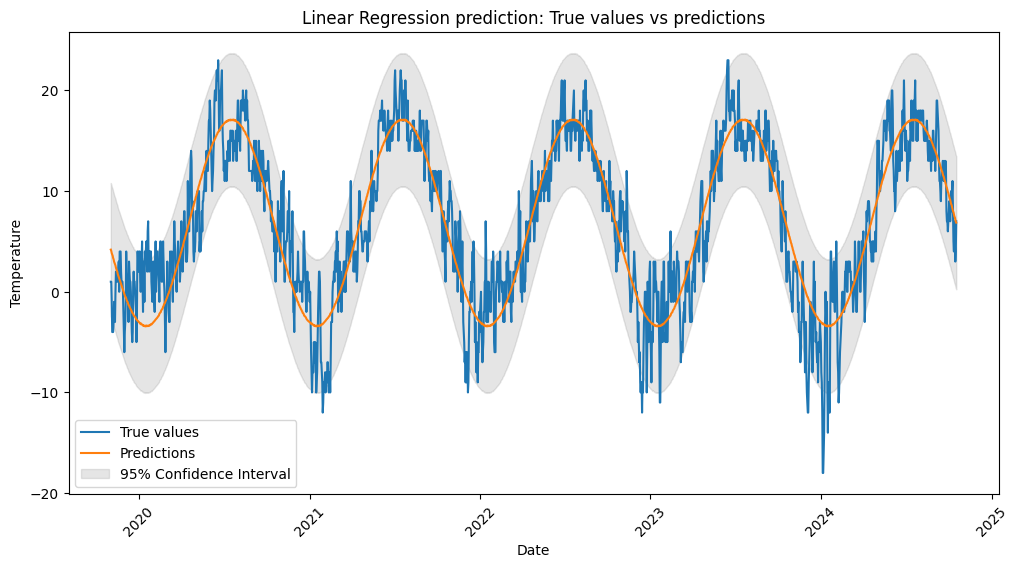

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
mse = evaluator.evaluate(predictions, {evaluator.metricName: "mse"})
mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})

margin_of_error = 1

dates = test_df.select("date").collect()
actual = np.array([row[0] for row in test_df.select("temperature").collect()])

dates = [datetime.strptime(date[0], '%Y-%m-%d') for date in dates]

predictions = np.array([row[0] for row in predictions.select("prediction").collect()])
residuals = actual - predictions
    
std_residuals = np.std(residuals)

z_score = 1.96 
prediction_intervals = z_score * std_residuals

lower_bounds = predictions - prediction_intervals
upper_bounds = predictions + prediction_intervals

within_confidence_interval = np.logical_and(
    actual >= lower_bounds,
    actual <= upper_bounds
)

percentage_within_interval = np.mean(within_confidence_interval) * 100

absolute_differences = np.abs(actual - predictions)

within_margin_of_error = absolute_differences <= margin_of_error

percentage_within_margin = np.mean(within_margin_of_error) * 100
    
plt.figure(figsize=(12, 6))
plt.plot(dates, actual, label="True values")
plt.plot(dates, predictions, label="Predictions")
plt.fill_between(dates, lower_bounds, upper_bounds, color='gray', alpha=0.2, label="95% Confidence Interval")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title(f"Linear Regression prediction: True values vs predictions")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [5]:
print(f"Linear Regression MAE: {mae}")
print(f"Linear Regression RMSE: {rmse}")
print(f"Linear Regression MSE: {mse}")
print(f"percentage within confidence interval: {percentage_within_interval}%")
print(f"Percentage within margin of error: {percentage_within_margin}%")

Linear Regression MAE: 2.660881163221651
Linear Regression RMSE: 3.377182583615701
Linear Regression MSE: 11.405362203077221
percentage within confidence interval: 95.03036996134733%
Percentage within margin of error: 23.08117062396466%


In [6]:
spark.stop()